# Notebook to segment fetal images using different methods

Class description:

    Label: 0 (Background)
    Label: 1 (third_sylvian, line)
    Label: 2 (third_midline, line)
    Label: 3 (third_cavum, area)
    Label: 4 (third_cerebellum, area)

Channel description:

    Channel: 1 (grayscale)

In [1]:
import os
from time import strftime
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from skimage import io as skio
from scipy.special import softmax

import torch
from torch.utils.data import DataLoader

from datasets import FetalDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, normalise

from pathlib import Path

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects) and sklearn (and its image analysis extension). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Reading Data
  

In [2]:
path = '/Users/ikaros/Downloads/Registered_segmentations/'

lDict = {"third_sylvian" : (1,False), "third_midline": (2,False), "third_cavum": (3,True), "third_cerebellum":(4,True)} 

FRds = FetalDataset(path,False)

In [3]:
def visualize_fetal_dataset(dataset, n=3):
    """
    Display `n` samples from a FetalDataset instance.
    
    Each sample shows:
    - The ultrasound image
    - The corresponding label mask
    """
    for i in range(min(n, len(dataset))):
        us_image, label_mask = dataset[i]

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        us_image_flipped = np.moveaxis(us_image, 0, -1)
        
        axes[0].imshow(us_image_flipped / np.max(us_image_flipped), cmap='gray')
        axes[0].set_title("Ultrasound Image")
        axes[0].axis("off")

        axes[1].imshow(label_mask, cmap='tab10', vmin=0)
        axes[1].set_title("Label Mask")
        axes[1].axis("off")

        axes[2].imshow(us_image_flipped / np.max(us_image_flipped), cmap='gray')
        axes[2].imshow(label_mask, cmap='tab10', vmin=0, alpha = 0.4)
        axes[2].set_title("Overlay")
        axes[2].axis("off")

        print(np.unique(label_mask))
        
        plt.tight_layout()
        plt.show()

[0 1 2 3 4]


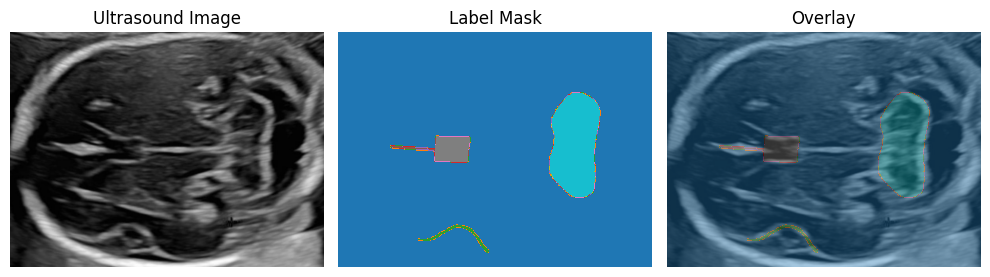

[0 1 2 3 4]


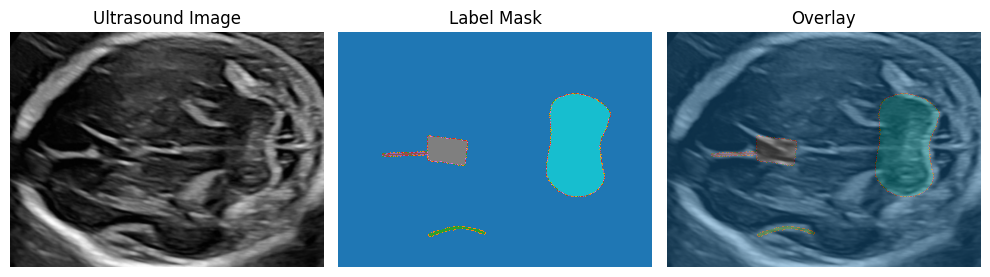

[0 1 2 3 4]


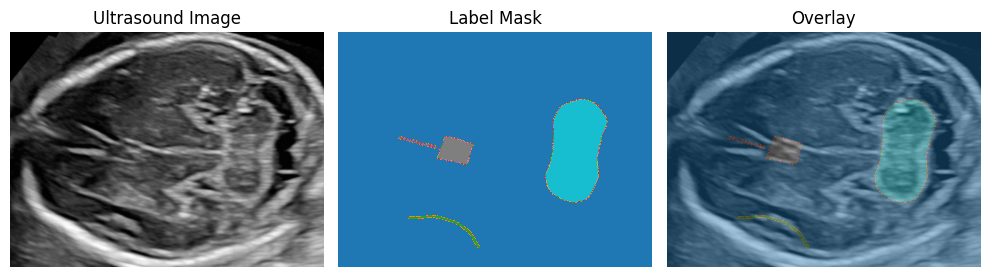

In [4]:
visualize_fetal_dataset(FRds)

In [5]:
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=4, test_batch=10, saliency_batch=4, verbose=1
):
    
    training_set, validation_set = training_data.breakTrainValid(0.8)

    print(len(training_data), len(training_set), len(validation_set))

    # make paths if they did not exist
    for d in [weight_path,maps_path]: Path(d).mkdir(parents=True, exist_ok=True)
    
    # Choosing random runs.
    np.random.seed(master_seed)
    seeds = np.random.randint(0, 100000, n_seeds)
    c = color_codes()

    dsc_list = []
    class_dsc_list = []
    # Main loop to run each independent random experiment.
    for test_n, seed in enumerate(seeds):
        acc = 0
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # The network will only be instantiated with the number of output classes
        # (2 in this notebok). Therefore, networks that need extra parameters (like ViT)
        # will need to be passed as a partial function.
        net = network_f(n_inputs=n_inputs, n_outputs=n_classes)
               
        # This is a leftover from legacy code. If init is set to True (the default option),
        # a first validation epoch will be run to determine the loss before training.
        net.init = False
        
        # The number of parameters is only captured for debugging and printing.
        n_param = sum(
            p.numel() for p in net.parameters() if p.requires_grad
        )

        if verbose > 1:
            print(
                '{:}[{:}] {:}Starting experiment {:}(seed {:05d} - {:} {:}[{:,} parameters]{:})'
                '{:} [{:02d}/{:02d}] {:}for {:} segmentation{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['b'] + display_name,
                    c['nc'], n_param, c['y'],
                    c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], c['nc']
                )
            )
        
        training_loader = DataLoader(
            training_set, train_batch, True
        )
        validation_loader = DataLoader(
            validation_set, test_batch
        )
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p.pt'.format(network_name, seed)
        )
        
        # For efficiency, we only run the code once. If the weights are
        # stored on disk, we do not need to train again.
        try:
            net.load_model(model_path)
        except IOError:
            net.train()
            print(''.join([' '] * 200), end='\r')
            net.fit(training_loader, validation_loader, epochs=epochs, patience=patience)
            net.save_model(model_path)
        
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}Testing {:}(seed {:05d}){:} [{:02d}/{:02d}] '
                '{:}for {:} segmentation <{:03d} samples>{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], 
                    len(training_set), c['nc']
                )
            )
        
        # Metric evaluation.
        net.eval()
        with torch.no_grad():
            mosaic_dsc = []
            mosaic_class_dsc = []
            # Intermediate buffers for class metrics.
            #for input_mosaic, mask_i in zip(testing_mosaics, testing_masks):
            for input_mosaic, mask_i in testing_data:
                pred_map = net.inference(
                    np.expand_dims(
                        normalise(input_mosaic).astype(np.float32),
                        axis=0
                    )
                )[0]
            
                pred_y = np.argmax(pred_map, axis=0).astype(np.uint8)
                y = mask_i.astype(np.uint8)
                intersection = np.stack([
                    2 * np.sum(np.logical_and(pred_y == lab, y == lab))
                    for lab in range(n_classes)
                ])
                card_pred_y = np.stack([
                    np.sum(pred_y == lab) for lab in range(n_classes)
                ])
                card_y = np.stack([
                    np.sum(y == lab) for lab in range(n_classes)
                ])
                dsc_k = intersection / (card_pred_y + card_y)
                dsc = np.nanmean(dsc_k)
                mosaic_dsc.append(dsc)
                mosaic_class_dsc.append(dsc_k.tolist())

                for i, map_i in enumerate(softmax(pred_map, axis=0)):
                    map_path = os.path.join(
                        maps_path, '{:}-balanced_s{:05d}_map_{:02d}.png'.format(
                            network_name, seed, i
                        )
                    )
                    final_map = (255 * map_i).astype(np.uint8)
                    skio.imsave(map_path, final_map.astype(np.uint8))
                map_path = os.path.join(
                    maps_path, '{:}-balanced_s{:05d}_masks.png'.format(
                        network_name, seed
                    )
                )
                final_map = (255 * (pred_y / (n_classes - 1))).astype(np.uint8)
                skio.imsave(map_path, final_map.astype(np.uint8))
                
                dsc = np.nanmean(mosaic_dsc, axis=0)
                class_dsc = np.nanmean(mosaic_class_dsc, axis=0)
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], dsc, c['nc']
                )
            )

            class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
                for k, dsc_k in zip(classes, class_dsc)
            ])
            print(
                '{:}[{:}] {:}Class DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'] + class_dsc_s + c['nc']
                )
            )
        elif verbose > 1:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                )
            )
        elif verbose > 0:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                ), end='\r'
            )
        net = None
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        dsc_list.append(mosaic_dsc)
        class_dsc_list.append(mosaic_class_dsc)
    
    # Metrics for all the runs.
    if verbose > 0:
        print(''.join([' '] * 200), end='\r')
        print(
            '{:}[{:}] {:} Mean DSC{:} {:5.3f}{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"),
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'], np.nanmean(dsc_list), c['nc']
            )
        )
        class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
            for k, dsc_k in zip(
                classes, np.nanmean(class_dsc_list, axis=(0, 1))
            )
        ])
        print(
            '{:}[{:}] {:} Mean class DSC {:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), 
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'] + class_dsc_s + c['nc']
            )
        )
        
    return dsc_list, class_dsc_list

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

master_seed = 42

train_batch = 8
test_batch = 8
epochs = 5
patience = 50
name = 'fetal us'
classes = ['background', "third_sylvian", "third_midline", "third_cavum", "third_cerebellum"]

d_path = "./data"
path_training = '/Users/ikaros/Downloads/Registered_segmentations/training/'
path_testing = '/Users/ikaros/Downloads/Registered_segmentations/testing/'

training_set = FetalDataset(path_training,False)
testing_set = FetalDataset(path_testing,False)
# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
    
# Unet [64, 64, 256, 256, 512, 512]
unet_dsc, unet_k_dsc = run_segmentation_experiments(
    master_seed, 'unet2d', 'Unet 2D', name,
    partial(Unet2D, lr=1e-4, conv_filters=[64, 64, 256, 256, 512, 512]),
    training_set, testing_set, 
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# FCN ResNet50
fcn50_dsc, fcn50_k_dsc = run_segmentation_experiments(
    master_seed, 'fcn-resnet50', 'FCN ResNet50', name,
    partial(FCN_ResNet50, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# FCN ResNet101
fcn101_dsc, fcn101_k_dsc = run_segmentation_experiments(
    master_seed, 'fcn-resnet101', 'FCN ResNet101', name,
    partial(FCN_ResNet101, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# DeeplapV3 MobileNet
dl3mn_dsc, dl3mn_k_dsc = run_segmentation_experiments(
    master_seed, 'deeplab3-mobilenet', 'DeeplabV3 MobileNet', name,
    partial(DeeplabV3_MobileNet, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# DeeplapV3 ResNet50
dl3rn_dsc, dl3rn_k_dsc = run_segmentation_experiments(
    master_seed, 'deeplab3-resnet50', 'DeeplabV3 ResNet50', name,
    partial(DeeplabV3_ResNet50, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

# L-RASPP ResNet50
lraspp_dsc, lraspp_k_dsc = run_segmentation_experiments(
    master_seed, 'lraspp-mobilenet', 'Lite R-ASPP MobileNet', name,
    partial(LRASPP_MobileNet, lr=1e-4, pretrained=True),
    training_set, testing_set,
    os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
    classes, n_inputs = 3, n_classes = 5, epochs=epochs, patience=patience,
    train_batch=train_batch, test_batch=test_batch, verbose=1
)

57 45 12
           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |                                                                                                                  
           ----------|---------|---------|----------|----------|----------|-------|
Epoch 000 (001/006 - 16.67%) [████                     ] train_loss 14.670794 (14.670794) 41s / ETA 3m 25s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

AssertionError: Torch not compiled with CUDA enabled